In [2]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, ElasticNetCV, RidgeCV, LassoCV, LassoLars
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import datetime

In [3]:
charging = pd.read_csv("../charging_sessions.csv", encoding = "ISO-8859-1")

In [4]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['connectionTime'] = charging['connectionTime'].dt.tz_localize(None)
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_localize(None)

charging = charging[~charging['id'].duplicated(keep=False)]

site_a = charging[charging["siteID"] == 1]
site_b = charging[charging["siteID"] == 2]



In [5]:
unique_spaces_a = site_a["stationID"].nunique()
unique_spaces_b = site_b["stationID"].nunique()

print(unique_spaces_a)
print(unique_spaces_b)

52
55


In [6]:
def create_utilization(df) -> pd.DataFrame:
    result = []

    # Filter unique days to include only those with at least one connection or disconnection
    relevant_days = pd.date_range(
        start=df['connectionTime'].dt.date.min(), 
        end=df['disconnectTime'].dt.date.max()
    )
    relevant_days = [
        day for day in relevant_days 
        if ((df['connectionTime'].dt.date <= day) & (df['disconnectTime'].dt.date >= day)).any()
    ]

    # Iterate through each relevant day
    for day in relevant_days:
        # Generate hourly time slots for the day
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        for time in time_slots:
            # Count the number of cars parked during this hour
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            result.append({'time': time.hour, 'utilization': utilization})

    # Convert the result list to a dataframe
    return pd.DataFrame(result)
utilization_a = create_utilization(site_a)
utilization_b = create_utilization(site_b)



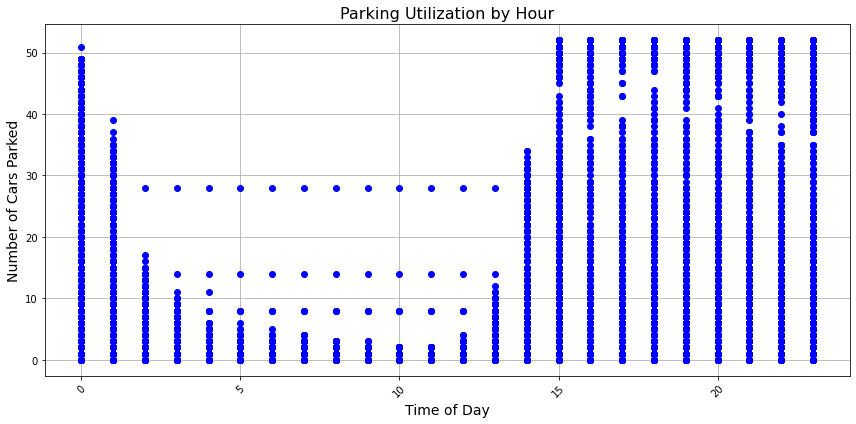

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(utilization_a['time'], utilization_a['utilization'], marker='o', linestyle='', color='b')

# Formatting the plot
plt.title('Parking Utilization by Hour', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

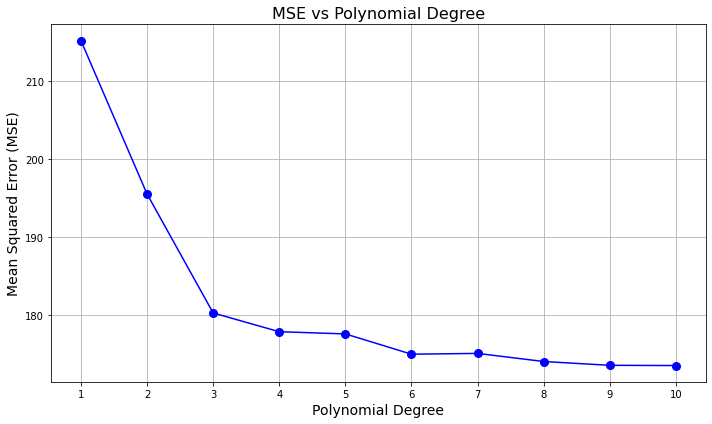

In [8]:
x_a = utilization_a["time"].values.reshape(-1, 1)
y_a = utilization_a["utilization"]

mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_a_train, y_a_train)

    # Make predictions
    y_a_pred = model.predict(x_a_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()

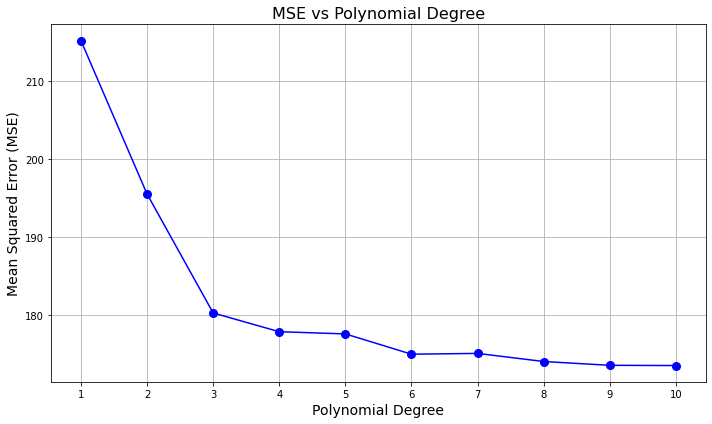

In [ ]:
x_a = utilization_a["time"].values.reshape(-1, 1)
y_a = utilization_a["utilization"]

mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_a_train, y_a_train)

    # Make predictions
    y_a_pred = model.predict(x_a_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()

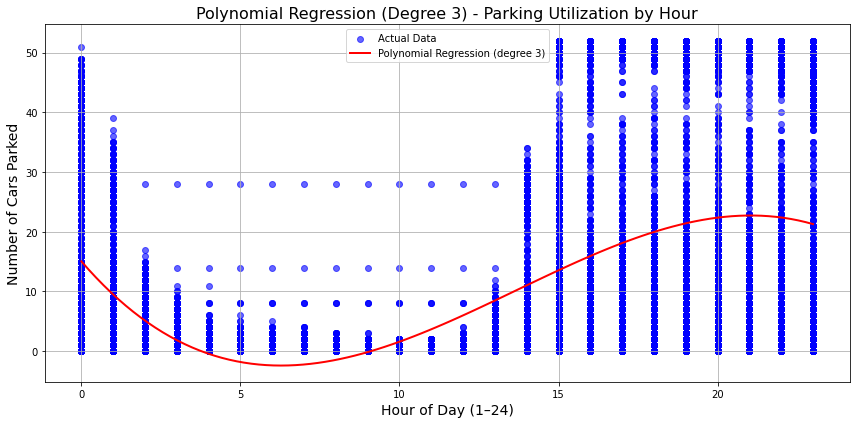

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Transform the feature to include polynomial terms (e.g., quadratic, cubic, etc.)
poly_degree = 3  # Degree of the polynomial (can be adjusted)
poly = PolynomialFeatures(degree=poly_degree)
x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_a_train, y_a_train)

# Make predictions
y_a_pred = model.predict(x_a_test)

mse = mean_squared_error(y_a_test, y_a_pred)

plt.figure(figsize=(12, 6))
plt.scatter(x_a, y_a, color='blue', label='Actual Data', alpha=0.6)  # Plot the actual data

# Plot the Polynomial Regression predictions
X_grid = np.linspace(min(x_a), max(x_a), 100).reshape(-1, 1)  # Create a smooth grid for the x-axis
y_grid = model.predict(poly.transform(X_grid))  # Predict using the polynomial features

plt.plot(X_grid, y_grid, color='red', label=f'Polynomial Regression (degree {poly_degree})', linewidth=2)  # Plot the polynomial predictions

plt.title(f'Polynomial Regression (Degree {poly_degree}) - Parking Utilization by Hour', fontsize=16)
plt.xlabel('Hour of Day (1–24)', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

neural network

In [ ]:
# Standardize the features (important for neural networks)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_val)

# # Build the neural network model
# model = Sequential()
# # Input layer (9 input features) and a hidden layer
# model.add(Dense(64, input_dim=3, activation='relu'))  # 64 units, ReLU activation
# # Another hidden layer
# model.add(Dense(32, activation='relu'))  # 32 units, ReLU activation
# # Output layer (single integer prediction)
# model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Build the neural network model (more complex with more layers and parameters)
model = Sequential()

# Input layer (9 input features) and first hidden layer
model.add(Dense(512, input_dim=1, activation='relu'))  # 512 units, ReLU activation
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second hidden layer
model.add(Dense(256, activation='relu'))  # 256 units, ReLU activation
model.add(Dropout(0.2))  # Dropout layer

# Third hidden layer
model.add(Dense(128, activation='relu'))  # 128 units, ReLU activation
model.add(Dropout(0.2))  # Dropout layer

# Fourth hidden layer
model.add(Dense(64, activation='relu'))  # 64 units, ReLU activation

# Output layer (single integer prediction)
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # Mean Squared Error loss
#model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),  # You can customize learning rate and momentum
              #loss='mse',  # Mean Squared Error loss
              #metrics=['mae'])  # Mean Absolute Error


# Train the model
history = model.fit(x_a_train, y_a_train, epochs=80, batch_size=32, validation_data=(x_a_test, y_a_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_a_test, y_a_test)

# Make predictions
predictions = model.predict(x_a_test)

# Create a smooth grid for the x-axis
X_grid = np.linspace(min(x_a_test[:, 0]), max(x_a_test[:, 0]), 100).reshape(-1, 1)

# Neural networks typically require the same input shape as during training
# If the model requires 5 features, replicate the X_grid as necessary
X_grid_extended = np.hstack([X_grid])  # Repeat the X_grid for each feature

# Predict using the trained neural network
y_grid = model.predict(X_grid_extended)

# Plot the actual data points
plt.figure(figsize=(12, 6))
plt.scatter(x_a[:, 0], y_a, color='blue', label='Actual Data', alpha=0.6)  # Assuming x_a has at least one feature

# Plot the neural network's predictions
plt.plot(X_grid[:, 0], y_grid, color='red', label='Neural Network Predictions', linewidth=2)

# Update the title and labels to reflect the neural network model
plt.title('Neural Network Predictions - Parking Utilization by Hour', fontsize=16)
plt.xlabel('Hour of Day (1–24)', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Site B

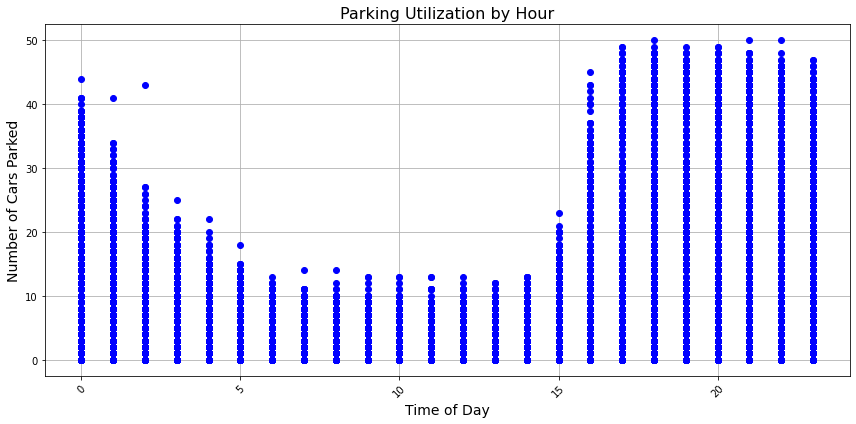

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(utilization_b['time'], utilization_b['utilization'], marker='o', linestyle='', color='b')

# Formatting the plot
plt.title('Parking Utilization by Hour', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

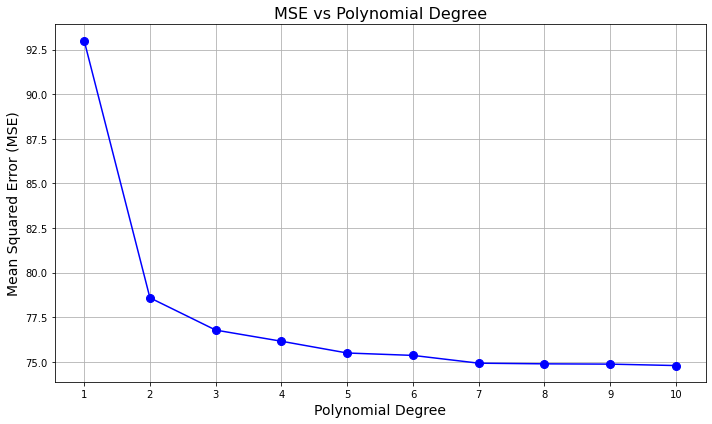

In [11]:
x_b = utilization_b["time"].values.reshape(-1, 1)
y_b = utilization_b["utilization"]

mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_b_poly = poly.fit_transform(x_b)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b_poly, y_b, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_b_train, y_b_train)

    # Make predictions
    y_b_pred = model.predict(x_b_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_b_test, y_b_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()

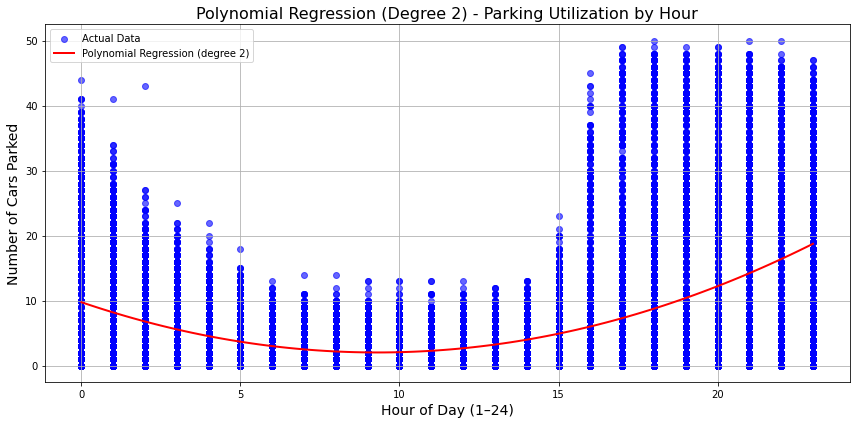

In [12]:
# Transform the feature to include polynomial terms (e.g., quadratic, cubic, etc.)
poly_degree = 2  # Degree of the polynomial (can be adjusted)
poly = PolynomialFeatures(degree=poly_degree)
x_b_poly = poly.fit_transform(x_b)  # Transform the data to include polynomial features

x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b_poly, y_b, test_size=0.3, random_state=42)

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_b_train, y_b_train)

# Make predictions
y_b_pred = model.predict(x_b_test)

mse = mean_squared_error(y_b_test, y_b_pred)

plt.figure(figsize=(12, 6))
plt.scatter(x_b, y_b, color='blue', label='Actual Data', alpha=0.6)  # Plot the actual data

# Plot the Polynomial Regression predictions
X_grid = np.linspace(min(x_b), max(x_b), 100).reshape(-1, 1)  # Create a smooth grid for the x-axis
y_grid = model.predict(poly.transform(X_grid))  # Predict using the polynomial features

plt.plot(X_grid, y_grid, color='red', label=f'Polynomial Regression (degree {poly_degree})', linewidth=2)  # Plot the polynomial predictions

plt.title(f'Polynomial Regression (Degree {poly_degree}) - Parking Utilization by Hour', fontsize=16)
plt.xlabel('Hour of Day (1–24)', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()